PCA차원수 줄이기. 정규화하기.  


# 비상장 중소기업의 상장 후 주가 예측 프로젝트

이 프로젝트는 비상장 중소기업의 상장 후 주가 예측 프로젝트다. 과거 중소기업이 상장 후 주가의 산술평균을 타겟값으로 지도 학습 알고리즘을 사용할 것이다.

기본설정

In [2]:
import numpy as np 
import os  
import matplotlib ##그림용
import matplotlib.pyplot as plt ##그림용
import sklearn ##사이킷런
import pandas as pd

np.random.seed(42) ##랜덤시드 

matplotlib.rc('font', family='NanumBarunGothic') ##matplotlib 한글을 위해
plt.rcParams['axes.unicode_minus'] = False ##한글을 위해

In [3]:
data = pd.read_csv('datasets//DB//DB_data.csv', engine='python')

# 기업규모명

우리가 예측하고 싶은 대상은 중소기업이므로 중소기업만 관찰한다.

In [4]:
data = data[data["기업규모명"] == '중소기업']

In [5]:
data = data[data["산술평균"] < 100000]

데이터를 간략하게 살펴보자

In [6]:
data.head()

,회사명,회계년도,산업명,소속코드,설립일,종업원,당좌자산(*),재고자산(*),비유동자산(*),유동부채(*),...,기업규모명,산술평균,경제성장률,총저축률,제조업 평균가동률,실업률,코스피지수,경상수지,merge,발행주식수
0,(주)CMG제약,2011-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,9917659.0,3104211.0,15477735.0,4969819.0,...,중소기업,873.0,1.0,34.1,81.3,4.2,1939.30,-4253.0,(주)CMG제약201103,108887244.0
1,(주)CMG제약,2011-06-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11341653.0,3071427.0,14731279.0,5976935.0,...,중소기업,577.0,0.6,34.1,80.6,3.4,2142.47,-2470.6,(주)CMG제약201106,108887244.0
2,(주)CMG제약,2011-09-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,11407699.0,3352328.0,14717723.0,6389723.0,...,중소기업,993.0,0.7,34.8,80.9,3.1,1880.11,11405.6,(주)CMG제약201109,108887244.0
3,(주)CMG제약,2011-12-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,12521782.0,2743103.0,12283654.0,7620349.0,...,중소기업,775.0,0.6,35.2,79.3,2.9,1847.51,11956.2,(주)CMG제약201112,108887244.0
4,(주)CMG제약,2012-03-01,의료용 물질 및 의약품 제조업,5.0,2001-08-01,213.0,13370740.0,3654331.0,12100895.0,8146944.0,...,중소기업,892.0,0.5,34.3,79.7,3.8,2045.08,-1292.0,(주)CMG제약201203,108887244.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19326 entries, 0 to 47807
Data columns (total 42 columns):
회사명                  19326 non-null object
회계년도                 19326 non-null object
산업명                  19326 non-null object
소속코드                 19326 non-null float64
설립일                  19326 non-null object
종업원                  19326 non-null float64
당좌자산(*)              19055 non-null float64
재고자산(*)              19055 non-null float64
비유동자산(*)             19055 non-null float64
유동부채(*)              19055 non-null float64
비유동부채(*)             19055 non-null float64
자본금(*)               19055 non-null float64
자본잉여금(*)             19055 non-null float64
자본조정(*)              19055 non-null float64
기타포괄손익누계액(*)         19055 non-null float64
이익잉여금(*)             19055 non-null float64
매출액(영업수익)(*)         19055 non-null float64
매출원가(*)              19055 non-null float64
매출총이익(손실)            19055 non-null float64
판매비와관리비(영업비용)(*)     19055 non-null float64
영업이익(손실)       

# 파일 정제

결측치가 몇 개 보인다.  산술평균에 경우 우리의 타겟값이므로 산술평균의 결측치가 있는 경우 객체를 버린다.

In [8]:
data = data[-(data["산술평균"].isnull())]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19326 entries, 0 to 47807
Data columns (total 42 columns):
회사명                  19326 non-null object
회계년도                 19326 non-null object
산업명                  19326 non-null object
소속코드                 19326 non-null float64
설립일                  19326 non-null object
종업원                  19326 non-null float64
당좌자산(*)              19055 non-null float64
재고자산(*)              19055 non-null float64
비유동자산(*)             19055 non-null float64
유동부채(*)              19055 non-null float64
비유동부채(*)             19055 non-null float64
자본금(*)               19055 non-null float64
자본잉여금(*)             19055 non-null float64
자본조정(*)              19055 non-null float64
기타포괄손익누계액(*)         19055 non-null float64
이익잉여금(*)             19055 non-null float64
매출액(영업수익)(*)         19055 non-null float64
매출원가(*)              19055 non-null float64
매출총이익(손실)            19055 non-null float64
판매비와관리비(영업비용)(*)     19055 non-null float64
영업이익(손실)       

이 경우 결측치가 있는 데이터가 소수일 것이라 생각되어 결측치가 있는 데이터를 버리는 것이 좋을 것 같다.

In [9]:
data = data[-data["당좌자산(*)"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19055 entries, 0 to 47807
Data columns (total 42 columns):
회사명                  19055 non-null object
회계년도                 19055 non-null object
산업명                  19055 non-null object
소속코드                 19055 non-null float64
설립일                  19055 non-null object
종업원                  19055 non-null float64
당좌자산(*)              19055 non-null float64
재고자산(*)              19055 non-null float64
비유동자산(*)             19055 non-null float64
유동부채(*)              19055 non-null float64
비유동부채(*)             19055 non-null float64
자본금(*)               19055 non-null float64
자본잉여금(*)             19055 non-null float64
자본조정(*)              19055 non-null float64
기타포괄손익누계액(*)         19055 non-null float64
이익잉여금(*)             19055 non-null float64
매출액(영업수익)(*)         19055 non-null float64
매출원가(*)              19055 non-null float64
매출총이익(손실)            19055 non-null float64
판매비와관리비(영업비용)(*)     19055 non-null float64
영업이익(손실)       

발행주식수에 결측치가 있는 샘플이 있다.

In [10]:
data = data[-data["발행주식수"].isnull()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19028 entries, 0 to 47807
Data columns (total 42 columns):
회사명                  19028 non-null object
회계년도                 19028 non-null object
산업명                  19028 non-null object
소속코드                 19028 non-null float64
설립일                  19028 non-null object
종업원                  19028 non-null float64
당좌자산(*)              19028 non-null float64
재고자산(*)              19028 non-null float64
비유동자산(*)             19028 non-null float64
유동부채(*)              19028 non-null float64
비유동부채(*)             19028 non-null float64
자본금(*)               19028 non-null float64
자본잉여금(*)             19028 non-null float64
자본조정(*)              19028 non-null float64
기타포괄손익누계액(*)         19028 non-null float64
이익잉여금(*)             19028 non-null float64
매출액(영업수익)(*)         19028 non-null float64
매출원가(*)              19028 non-null float64
매출총이익(손실)            19028 non-null float64
판매비와관리비(영업비용)(*)     19028 non-null float64
영업이익(손실)       

# 데이터 시각화

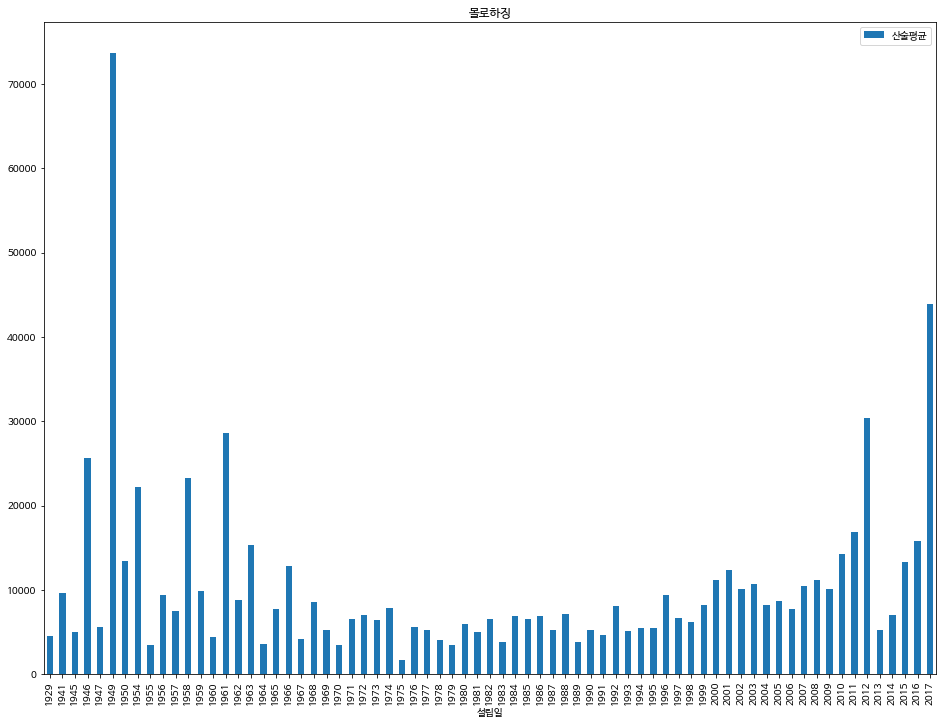

In [11]:
tmp1 = data[["설립일", "산술평균"]].copy()
tmp1["설립일"] = tmp1["설립일"].str.split('-', n=2, expand=True)[0]

tmp1.groupby("설립일").mean().plot.bar(figsize=(16,12))
plt.title("몰로하징")
plt.show()

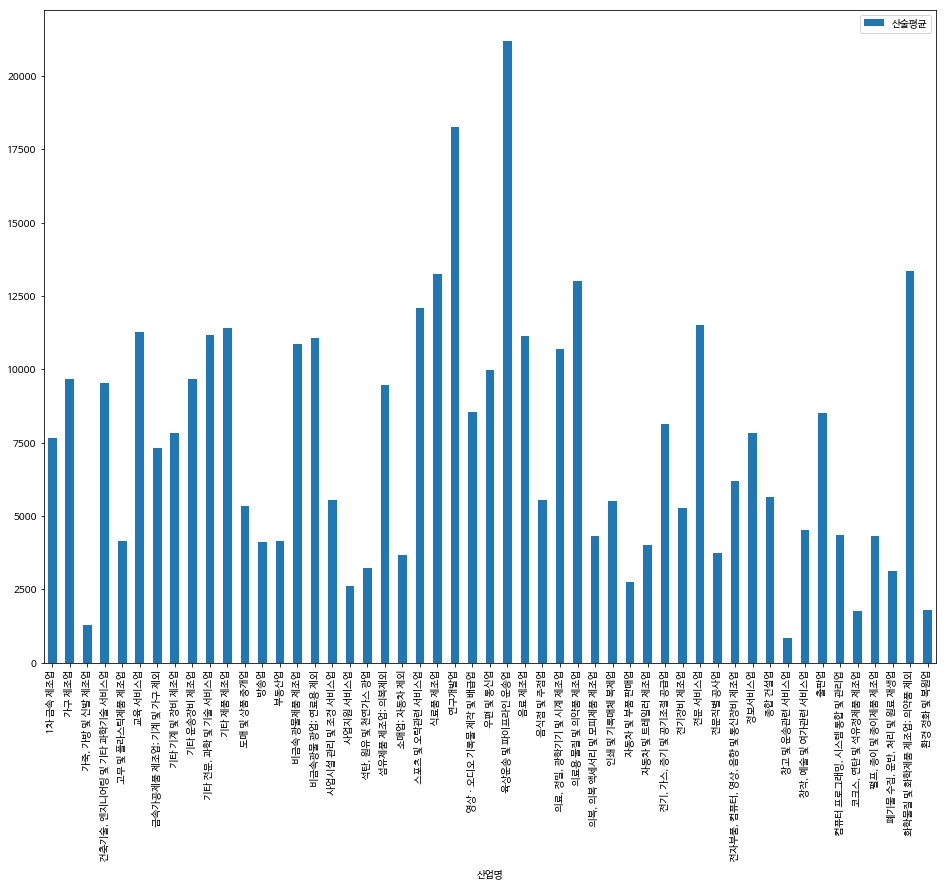

In [12]:
tmp2 = data[["산업명", "산술평균"]].copy()
tmp2.groupby(['산업명']).mean().plot.bar(figsize=(16,12))
plt.title("몰로하징")
plt.show()

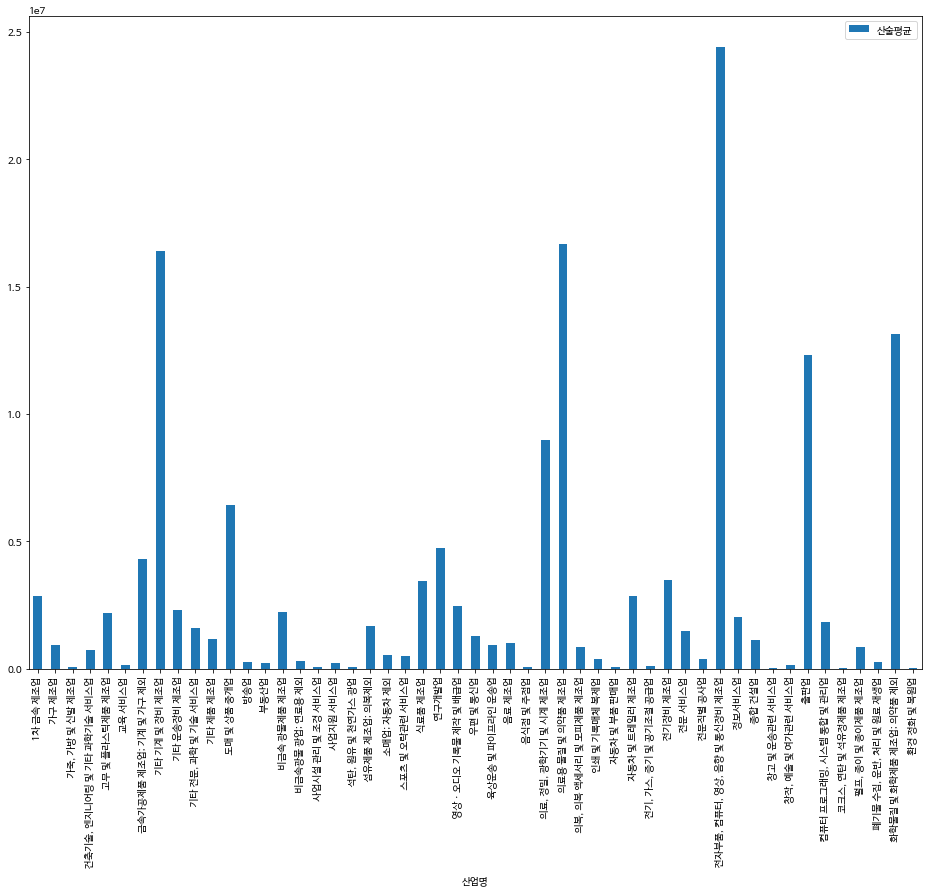

In [13]:
tmp2 = data[["산업명", "산술평균"]].copy()
tmp2.groupby(['산업명']).sum().plot.bar(figsize=(16,12))
plt.title("몰로하징")
plt.show()

In [14]:
tmp2["산업명"].value_counts()

  전자부품, 컴퓨터, 영상, 음향 및 통신장비 제조업    3949
  기타 기계 및 장비 제조업                  2088
  출판업                             1444
  의료용 물질 및 의약품 제조업                1279
  도매 및 상품 중개업                     1207
  화학물질 및 화학제품 제조업; 의약품 제외          984
  의료, 정밀, 광학기기 및 시계 제조업            837
  자동차 및 트레일러 제조업                   706
  전기장비 제조업                         665
  금속가공제품 제조업; 기계 및 가구 제외           589
  고무 및 플라스틱제품 제조업                  521
  컴퓨터 프로그래밍, 시스템 통합 및 관리업          419
  1차 금속 제조업                        370
  영상ㆍ오디오 기록물 제작 및 배급업              288
  연구개발업                            260
  정보서비스업                           260
  식료품 제조업                          258
  기타 운송장비 제조업                      238
  비금속 광물제품 제조업                     203
  종합 건설업                           198
  의복, 의복 액세서리 및 모피제품 제조업           197
  펄프, 종이 및 종이제품 제조업                196
  섬유제품 제조업; 의복제외                   175
  기타 전문, 과학 및 기술 서비스업              144
  소매업; 자동차 제외                      143
  전문 서비스업                

육상운송 및 파이프라인 운송업 44, 연구개발 260개 산술 평균은 큼

In [15]:
tmp3= data[["종업원", "산술평균"]]

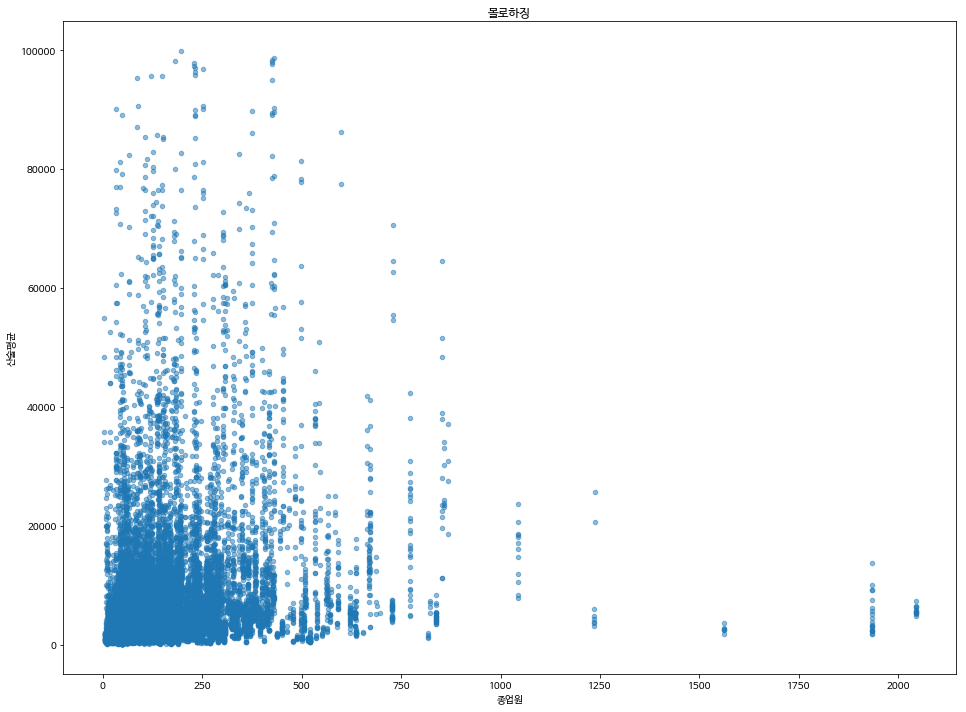

In [19]:
tmp3.plot(kind="scatter", x='종업원', y='산술평균', alpha=0.5, figsize=(16,12))
plt.title("몰로하징")
plt.show()

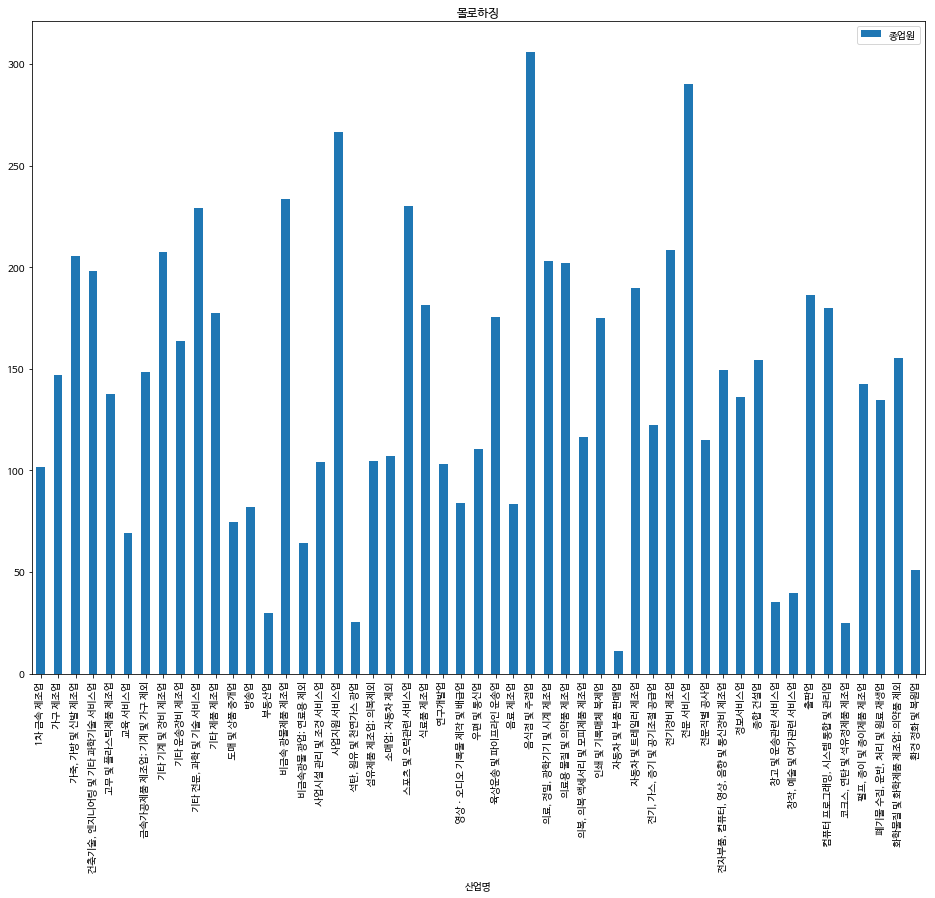

In [22]:
tmp4 = data[[ "산업명","종업원"]]

tmp4.groupby("산업명").mean().plot.bar(figsize=(16,12))
plt.title("몰로하징")
plt.show()

In [29]:
corr_matrix = data.corr()
corr_matrix["산술평균"].sort_values(ascending=False)

산술평균                 1.000000
영업이익(손실)             0.322217
당좌자산(*)              0.297692
법인세비용차감전(계속사업)손익     0.286867
당기순이익(순손실)           0.275018
계속사업이익(손실)           0.273657
매출총이익(손실)            0.268652
이익잉여금(*)             0.248753
(계속사업손익)법인세비용        0.217299
영업활동으로 인한 현금흐름(*)    0.196629
자본잉여금(*)             0.185462
종업원                  0.168027
비유동자산(*)             0.159903
판매비와관리비(영업비용)(*)     0.152553
매출액(영업수익)(*)         0.127338
  총저축률               0.112448
  경상수지               0.077800
재무활동으로 인한 현금흐름(*)    0.072792
현금의 증가(감소)(*)        0.062943
매출원가(*)              0.062928
 코스피지수               0.062633
비유동부채(*)             0.061335
  실업률                0.050573
재고자산(*)              0.048700
영업외수익(*)             0.045389
유동부채(*)              0.023665
기타포괄손익누계액(*)         0.018638
환율변동으로 인한 차이조정      -0.010371
  경제성장률             -0.012812
영업외비용(*)            -0.016143
소속코드                -0.025481
자본조정(*)             -0.032230
  제조업 평균가동률         -0.119787
투자활동으로 인한 

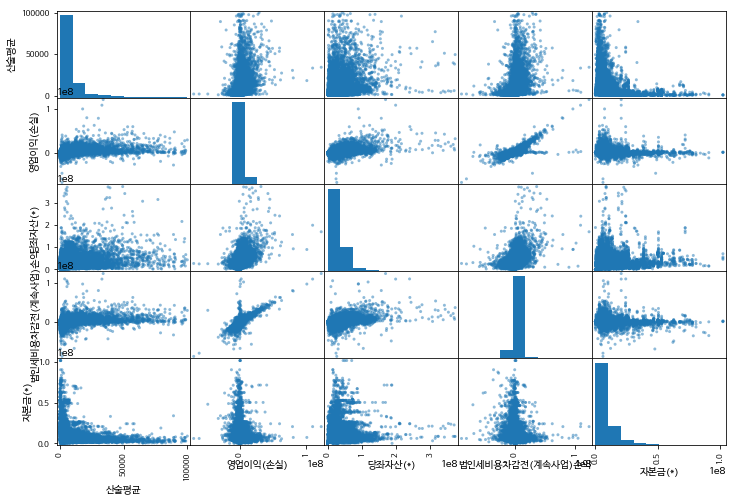

In [35]:
from pandas.plotting import scatter_matrix

attributes1 = ["산술평균","영업이익(손실)", "당좌자산(*)", "법인세비용차감전(계속사업)손익", "자본금(*)"]
scatter_matrix(data[attributes1], figsize=(12, 8))
plt.show()

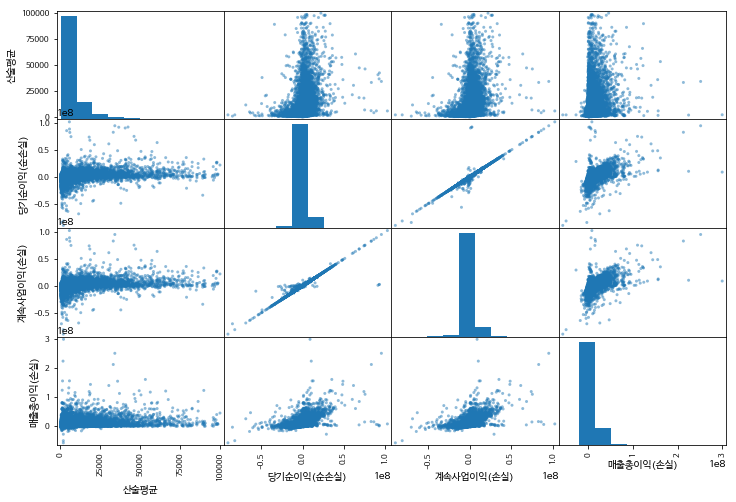

In [38]:
from pandas.plotting import scatter_matrix

attributes2 = ["산술평균","당기순이익(순손실)", "계속사업이익(손실)", "매출총이익(손실)"]
scatter_matrix(data[attributes2], figsize=(12, 8))
plt.show()

# 머신러닝에 넣기 위해 데이터를 전처리하자.

train 데이터와 test 데이터를 나누자.

In [13]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(data, test_size=0.2, random_state=42)

test의 경우 나중에 모델을 평가할 때 사용하자.

In [14]:
labels = train["산술평균"]
train.drop(["산술평균"], axis=1, inplace=True)

c:\users\student\documents\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


주어진 미시 변수에 경우 서로의 상관관계가 높을 것이라 생각되어, PCA알고리즘을 이용하여 차원을 줄이도록 하자.

In [15]:
micro_val = ['당좌자산(*)','재고자산(*)','비유동자산(*)','유동부채(*)','비유동부채(*)',
        '자본금(*)','자본잉여금(*)','자본조정(*)','기타포괄손익누계액(*)',
        '이익잉여금(*)','매출액(영업수익)(*)','매출원가(*)','매출총이익(손실)',
        '판매비와관리비(영업비용)(*)','영업이익(손실)','영업외수익(*)','영업외비용(*)',
        '법인세비용차감전(계속사업)손익','(계속사업손익)법인세비용','계속사업이익(손실)',
        '당기순이익(순손실)','영업활동으로 인한 현금흐름(*)',
        '투자활동으로 인한 현금흐름(*)','재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정','현금의 증가(감소)(*)']

X = train[micro_val]

먼저 주어진 데이터를 95%이상 설명가능한 차원의 수를 구하자.

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_) ## 모든 배열의 원소들을 누적으로 다 더한 놈들 반환
d = np.argmax(cumsum>=0.90)+1 ## argmax는 제일 큰 수의 index를 1차원 배열로 봤을 때의 index로 반환
# d = 9
## 9차원이면 주어진 데이터를 95%이상 설명할 수 있다.
pca = PCA(n_components=d)

pca.fit_transform(X), d

(array([[-31472002.46111395,  13186177.27213328,  -4515026.10852822,
         -26859700.62417275,    424601.70146136,  10487749.66802431],
        [-49468907.23496043,  -6299476.52963541,  -5076607.9047085 ,
         -21492763.24884566,  -4569871.47536669,   7062064.85208976],
        [-20046814.84116377,  -9844795.00034529,  19643063.81764062,
          -5662401.20311373,  -5520943.25456841,  19929333.14887938],
        ...,
        [ 24520482.86963775, -19524241.63779491, -25181079.87719313,
          23062417.85752596,  -6249648.79404879, -10108889.33059697],
        [-36247960.08829786,  14179386.59627471,  -5986318.42017341,
          17287994.35793713,  -6206285.06943803,   1221886.64493607],
        [-19975435.50898137,   7614416.74650563,   3044363.43033154,
         -10235423.35980839,  50850687.58360406,  10532287.92340862]]), 6)

전처리를 위한 파이프라인

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

class drop_some_attributes(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["회사명", "기업규모명", "소속코드"], axis=1)

class date_of_establish(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["설립일"] = X["설립일"].str.split('-', n = 1, expand=True)[0].astype("float")
        return X
    
class PCA_K2H(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        pca.fit(X[micro_val])
        return self
    def transform(self, X, y=None):
        self.index_ = X.index
        
        col = []
        for i in range(d):
            col.append('pca%s' %i)
        
        XdD = pd.DataFrame(pca.transform(X[micro_val]), 
                          index=self.index_, columns = col)
        
        X.drop(micro_val, axis=1, inplace=True)
        return X.join(XdD)
    
class add_quater(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["분기"] = X["회계년도"].str.split("-", n=2, expand=True)[1]
        X.drop(["회계년도"], axis=1, inplace=True)
        return X

파이프라인 준비

In [19]:
train.columns

Index(['회사명', '회계년도', '산업명', '소속코드', '설립일', '종업원', '당좌자산(*)', '재고자산(*)',
       '비유동자산(*)', '유동부채(*)', '비유동부채(*)', '자본금(*)', '자본잉여금(*)', '자본조정(*)',
       '기타포괄손익누계액(*)', '이익잉여금(*)', '매출액(영업수익)(*)', '매출원가(*)', '매출총이익(손실)',
       '판매비와관리비(영업비용)(*)', '영업이익(손실)', '영업외수익(*)', '영업외비용(*)',
       '법인세비용차감전(계속사업)손익', '(계속사업손익)법인세비용', '계속사업이익(손실)', '당기순이익(순손실)',
       '영업활동으로 인한 현금흐름(*)', '투자활동으로 인한 현금흐름(*)', '재무활동으로 인한 현금흐름(*)',
       '환율변동으로 인한 차이조정', '현금의 증가(감소)(*)', '기업규모명', '  경제성장률', '  총저축률',
       '  제조업 평균가동률', '  실업률', ' 코스피지수', '  경상수지', 'merge', '발행주식수'],
      dtype='object')

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_attributes = ["산업명", '회계년도']
num_attributes = []
for i in train.columns:
    if i not in cat_attributes:
        num_attributes.append(i)

In [30]:
num_pipeline = Pipeline([
        ('drop회사년도,회사명,기업규모명,소속코드',drop_some_attributes()),
        ('설립일',date_of_establish()),
        ('PCA_micro_att',PCA_K2H()),
        ('StandardScaler',StandardScaler()),
    ])

In [31]:
cat_pipeline = Pipeline([
        ('add_quater', add_quater()),
        ('onehotencoder',OneHotEncoder(categories='auto')),
    ])

In [32]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes),
        ("cat", cat_pipeline, cat_attributes),
    ])

In [35]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(15222, 70)

## 머신러닝 트레이닝

In [36]:
from sklearn.metrics import mean_squared_error

### LinearRegression

In [37]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, labels)

train_predictions = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(labels, train_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

8947.390869072276

### DecisionTreeRegressor

In [21]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42, max_depth=10)

tree_reg.fit(train_prepared, labels)

train_predictions = tree_reg.predict(train_prepared)
tree_mse = mean_squared_error(labels, train_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

8184.70941613182

### RandomForestRegressor

In [146]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=50)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

3255.3394750346715

## cross_val_score

In [38]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [24]:
scores = cross_val_score(lin_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [11072.17905471 16149.72151747 18635.51978405 15740.87322823
 17882.63950003 21774.31361722 14403.22465035 19999.22667613
 23947.17568314 17914.32316503]
Mean: 17751.91968763638
Standard deviation: 3505.417098986143


In [25]:
scores = cross_val_score(tree_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [13286.49024493  9320.81549323 23115.05811894 12318.1604613
 20290.87509219 10174.71904463  9106.20580367 25997.17207517
 25469.62890065 20861.14092553]
Mean: 16994.02661602358
Standard deviation: 6476.045583213977


In [26]:
scores = cross_val_score(forest_reg, train_prepared, labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 7928.19988723  8268.29919021 18246.41472499  9192.48247083
 17516.38201964  8126.08717251  6555.21348119 10992.92773446
 17532.04871108  9525.26769065]
Mean: 11388.332308278354
Standard deviation: 4318.437841906842


### 그리드 탐색

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                        scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_prepared, labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [28]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [29]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [30]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

17318.041436153348 {'max_features': 2, 'n_estimators': 3}
15064.334447230793 {'max_features': 2, 'n_estimators': 10}
14280.442945489222 {'max_features': 2, 'n_estimators': 30}
17123.615828710954 {'max_features': 4, 'n_estimators': 3}
14601.394075409115 {'max_features': 4, 'n_estimators': 10}
14199.19993876482 {'max_features': 4, 'n_estimators': 30}
16932.591753691828 {'max_features': 6, 'n_estimators': 3}
14569.107715215 {'max_features': 6, 'n_estimators': 10}
14073.227041455828 {'max_features': 6, 'n_estimators': 30}
18170.636424096883 {'max_features': 8, 'n_estimators': 3}
14327.984684457082 {'max_features': 8, 'n_estimators': 10}
13731.357653169549 {'max_features': 8, 'n_estimators': 30}
16352.111990671016 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
13865.217145327351 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
16295.457184768999 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
13922.67217060055 {'bootstrap': False, 'max_features': 3, 'n_esti

In [31]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=46, random_state=42, max_depth=45)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

4369.095683050813

In [32]:
scores = cross_val_score(forest_reg, train_prepared, labels,
        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [ 7818.29561395  7535.38904714 17958.21432616  9276.10446936
 17303.3323189   7909.89709791  6993.72546387 11344.23062698
 16650.60075675  9387.0902245 ]
Mean: 11217.687994552185
Standard deviation: 4159.587541355605


### 랜덤 그리드 탐색

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
from scipy.stats import randint as sp_randint

In [62]:
param_dist = {'n_estimators': [3, 10, 20, 30, 40],
                "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["mse"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
random_search.fit(train_prepared, labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=45,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=46, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': [3, 10, 20, 30, 40], 'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000019B762B0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001C760BE0>, 'bootstrap': [True, False], 'criterion': ['mse']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [63]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(mean_score), params)

0.3992775687473013 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 3, 'max_features': 6, 'min_samples_split': 6, 'n_estimators': 40}
0.8038885137491261 {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 9, 'min_samples_split': 9, 'n_estimators': 30}
0.8433996648320283 {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 9, 'min_samples_split': 4, 'n_estimators': 30}
0.3053190895512324 {'bootstrap': True, 'criterion': 'mse', 'max_depth': 3, 'max_features': 3, 'min_samples_split': 6, 'n_estimators': 40}
0.23474765305519876 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 3, 'max_features': 2, 'min_samples_split': 8, 'n_estimators': 3}
0.7660216968915127 {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 4, 'min_samples_split': 9, 'n_estimators': 40}
0.8215459327793488 {'bootstrap': False, 'criterion': 'mse', 'max_depth': None, 'max_features': 9, 'min_samples_split': 6, 'n_estimators': 10}
0.679690187053584

In [64]:
random_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

#### 랜덤 포레스트 마지막 

In [65]:
labels.mean()

7919.7369596636445

In [67]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
forest_reg.fit(train_prepared, labels)

train_predictions = forest_reg.predict(train_prepared)
forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1026.6329440854568

In [68]:
scores = cross_val_score(forest_reg, train_prepared, labels,
        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [5110.36313828 5729.57352585 5490.89050905 5077.33143011 5532.68384366
 6009.64478088 4829.28248028 6245.46596894 5559.64385497 5217.204186  ]
Mean: 5480.208371802462
Standard deviation: 415.8429878429595


많이 과대적합되어있는 것으로 보인다.

## 딥러닝

In [43]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
import random

def reset_graph(seed=42): ## 그래프에 변수가 쌓이는 것을 방지
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Using TensorFlow backend.


In [ ]:
train_prepared.shape

In [69]:
model = Sequential()
model.add(Dense(50, input_dim=train_prepared.shape[1], activation='elu')) ## input * 2/3
model.add(Dense(30, activation='elu'))
model.add(Dense(20, activation='elu'))
model.add(Dense(10, activation='elu'))
#model.add(Dropout(0.5))
model.add(Dense(1))

In [70]:
model.compile(optimizer='Adam', loss='mse')

In [ ]:
hist = model.fit(train_prepared, labels, epochs=10, batch_size=512)

Epoch 1/10
15222/15222 [==============================] - 0s 16us/step - loss: 175959686.0018
Epoch 2/10
15222/15222 [==============================] - 0s 6us/step - loss: 175873198.1332
Epoch 3/10
15222/15222 [==============================] - 0s 6us/step - loss: 175611068.5334
Epoch 4/10
15222/15222 [==============================] - 0s 6us/step - loss: 174612822.9457
Epoch 5/10
15222/15222 [==============================] - 0s 5us/step - loss: 171264245.3291
Epoch 6/10
15222/15222 [==============================] - 0s 6us/step - loss: 162306737.1016
Epoch 7/10
15222/15222 [==============================] - 0s 6us/step - loss: 144167235.9900
Epoch 8/10
15222/15222 [==============================] - 0s 6us/step - loss: 118809925.2513
Epoch 9/10
15222/15222 [==============================] - 0s 6us/step - loss: 98414919.0004
Epoch 10/10
15222/15222 [==============================] - 0s 6us/step - loss: 90051805.0296


그림으로 적절한 에포크 찾기. 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 94346669.9556
Epoch = 0 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 92912519.1302
Epoch = 1 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 91723891.8387
Epoch = 2 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 90792614.8501
Epoch = 3 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 89887899.5517
Epoch = 4 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 89102164.0499
Epoch = 5 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 88403455.7646
Epoch = 6 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 87727421.2151
Epoch = 7 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 87137790.1679
Epoch = 8 / 1500 

Epoch 1/1
7611/7611 [=======

Epoch = 149 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 68849708.0279
Epoch = 150 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 68719177.7948
Epoch = 151 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 68623308.3716
Epoch = 152 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 68505130.5111
Epoch = 153 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 68336238.7082
Epoch = 154 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 68225314.5831
Epoch = 155 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 68096030.5006
Epoch = 156 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 67950355.1165
Epoch = 157 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 67849537.6324
Epoch = 15

7611/7611 [==============================] - 0s 5us/step - loss: 51692876.6506
Epoch = 298 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 51535717.7385
Epoch = 299 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 51441433.9924
Epoch = 300 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 51298274.1206
Epoch = 301 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 51241607.4471
Epoch = 302 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 51269873.5930
Epoch = 303 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 51224381.1179
Epoch = 304 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 50976377.0233
Epoch = 305 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 50882969.5604
Epoch = 306 / 1500 

Epoch 1/1
7611/7611 

7611/7611 [==============================] - 0s 5us/step - loss: 37482477.3255
Epoch = 446 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 37441943.0608
Epoch = 447 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 37391987.8142
Epoch = 448 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 37347449.6660
Epoch = 449 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 37186999.5512
Epoch = 450 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 37360773.2529
Epoch = 451 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 37301399.0585
Epoch = 452 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 37096280.7192
Epoch = 453 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 36807525.2916
Epoch = 454 / 1500 

Epoch 1/1
7611/7611 

7611/7611 [==============================] - 0s 6us/step - loss: 26692599.3076
Epoch = 594 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 26635986.2733
Epoch = 595 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 26515923.2377
Epoch = 596 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 26623475.4006
Epoch = 597 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 26474705.7948
Epoch = 598 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 26299922.7523
Epoch = 599 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 26423651.0377
Epoch = 600 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 26211823.6460
Epoch = 601 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 26303084.6254
Epoch = 602 / 1500 

Epoch 1/1
7611/7611 

7611/7611 [==============================] - 0s 5us/step - loss: 19636758.6372
Epoch = 742 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19672806.5103
Epoch = 743 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19636891.6376
Epoch = 744 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 19880724.0859
Epoch = 745 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 19622664.9163
Epoch = 746 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19496906.3632
Epoch = 747 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19474666.8133
Epoch = 748 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19602693.8949
Epoch = 749 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 19400489.2277
Epoch = 750 / 1500 

Epoch 1/1
7611/7611 

7611/7611 [==============================] - 0s 5us/step - loss: 15303201.7442
Epoch = 890 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15326098.2213
Epoch = 891 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15232181.7870
Epoch = 892 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15192689.3591
Epoch = 893 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 15207774.5468
Epoch = 894 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 15149163.2805
Epoch = 895 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15244579.5612
Epoch = 896 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15134370.0356
Epoch = 897 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 15101685.0964
Epoch = 898 / 1500 

Epoch 1/1
7611/7611 

7611/7611 [==============================] - 0s 5us/step - loss: 12701530.8510
Epoch = 1038 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12833866.8691
Epoch = 1039 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 12726634.6991
Epoch = 1040 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 12757282.0903
Epoch = 1041 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12896927.3850
Epoch = 1042 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12712748.4105
Epoch = 1043 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12739339.7845
Epoch = 1044 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12681469.8364
Epoch = 1045 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 12565608.3948
Epoch = 1046 / 1500 

Epoch 1/1
7

7611/7611 [==============================] - 0s 6us/step - loss: 11872020.7438
Epoch = 1112 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 11983065.8404
Epoch = 1113 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 11780640.3775
Epoch = 1114 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 11687428.3244
Epoch = 1115 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11821290.6983
Epoch = 1116 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11835237.2044
Epoch = 1117 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11916101.0604
Epoch = 1118 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11859534.8806
Epoch = 1119 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11585638.2502
Epoch = 1120 / 1500 

Epoch 1/1
7

7611/7611 [==============================] - 0s 5us/step - loss: 10989607.6417
Epoch = 1186 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 11178975.6031
Epoch = 1187 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10984770.7109
Epoch = 1188 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 10921627.9541
Epoch = 1189 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10810083.5341
Epoch = 1190 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10933549.5985
Epoch = 1191 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10959449.1225
Epoch = 1192 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10871108.5196
Epoch = 1193 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 10803727.0748
Epoch = 1194 / 1500 

Epoch 1/1
7

7611/7611 [==============================] - 0s 6us/step - loss: 10269949.7092
Epoch = 1260 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10244786.0275
Epoch = 1261 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10161231.3551
Epoch = 1262 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10192939.2663
Epoch = 1263 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10196613.9192
Epoch = 1264 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10310398.3421
Epoch = 1265 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 10242298.0080
Epoch = 1266 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 10212234.6918
Epoch = 1267 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 10296181.9640
Epoch = 1268 / 1500 

Epoch 1/1
7

7611/7611 [==============================] - 0s 5us/step - loss: 9370579.5745
Epoch = 1408 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 9273810.5949
Epoch = 1409 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 9240703.0993
Epoch = 1410 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 9311198.3583
Epoch = 1411 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 9223779.4444
Epoch = 1412 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 9140201.0850
Epoch = 1413 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 9214730.1020
Epoch = 1414 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 5us/step - loss: 9251569.4852
Epoch = 1415 / 1500 

Epoch 1/1
7611/7611 [==============================] - 0s 6us/step - loss: 9163793.1458
Epoch = 1416 / 1500 

Epoch 1/1
7611/7611 

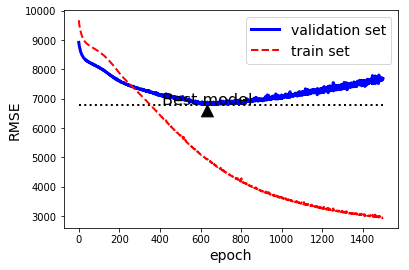

In [72]:
X_train, X_val, y_train, y_val = train_test_split(train_prepared, labels, test_size=0.5, random_state=10)

n_epochs = 1500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    hist = model.fit(X_train, y_train, epochs=1, batch_size=512)
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    print("Epoch = %s / %s \n" %(epoch,n_epochs) )

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="train set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [75]:
hist = model.fit(train_prepared, labels, epochs=630, batch_size=1024)

Epoch 1/630
15222/15222 [==============================] - 0s 5us/step - loss: 12198923.3174
Epoch 2/630
15222/15222 [==============================] - 0s 4us/step - loss: 12058575.3515
Epoch 3/630
15222/15222 [==============================] - 0s 4us/step - loss: 11966747.2152
Epoch 4/630
15222/15222 [==============================] - 0s 4us/step - loss: 11933533.0152
Epoch 5/630
15222/15222 [==============================] - 0s 4us/step - loss: 11857709.1373
Epoch 6/630
15222/15222 [==============================] - 0s 4us/step - loss: 11884521.4558
Epoch 7/630
15222/15222 [==============================] - 0s 4us/step - loss: 11845634.5015
Epoch 8/630
15222/15222 [==============================] - 0s 4us/step - loss: 11877125.3019
Epoch 9/630
15222/15222 [==============================] - 0s 4us/step - loss: 11867701.8412
Epoch 10/630
15222/15222 [==============================] - 0s 4us/step - loss: 11922633.6899
Epoch 11/630
15222/15222 [==============================] - 0s 4us/st

15222/15222 [==============================] - 0s 4us/step - loss: 10813276.8009
Epoch 175/630
15222/15222 [==============================] - 0s 4us/step - loss: 10838949.3720
Epoch 176/630
15222/15222 [==============================] - 0s 4us/step - loss: 10836731.2500
Epoch 177/630
15222/15222 [==============================] - 0s 4us/step - loss: 10805418.8090
Epoch 178/630
15222/15222 [==============================] - 0s 4us/step - loss: 10893618.3926
Epoch 179/630
15222/15222 [==============================] - 0s 4us/step - loss: 10930956.1889
Epoch 180/630
15222/15222 [==============================] - ETA: 0s - loss: 10770010.89 - 0s 4us/step - loss: 10786064.0759
Epoch 181/630
15222/15222 [==============================] - 0s 4us/step - loss: 10812827.9788
Epoch 182/630
15222/15222 [==============================] - 0s 4us/step - loss: 10828714.6178
Epoch 183/630
15222/15222 [==============================] - 0s 4us/step - loss: 10704224.3838
Epoch 184/630
15222/15222 [=======

15222/15222 [==============================] - 0s 4us/step - loss: 10442131.2854
Epoch 261/630
15222/15222 [==============================] - 0s 4us/step - loss: 10316783.9285
Epoch 262/630
15222/15222 [==============================] - 0s 4us/step - loss: 10305549.1452
Epoch 263/630
15222/15222 [==============================] - 0s 4us/step - loss: 10304767.1079
Epoch 264/630
15222/15222 [==============================] - 0s 4us/step - loss: 10268774.6734
Epoch 265/630
15222/15222 [==============================] - 0s 4us/step - loss: 10252411.2793
Epoch 266/630
15222/15222 [==============================] - 0s 4us/step - loss: 10309056.6889
Epoch 267/630
15222/15222 [==============================] - 0s 4us/step - loss: 10358919.7065
Epoch 268/630
15222/15222 [==============================] - 0s 4us/step - loss: 10352517.8485
Epoch 269/630
15222/15222 [==============================] - 0s 4us/step - loss: 10250716.6977
Epoch 270/630
15222/15222 [==============================] - 0s 

15222/15222 [==============================] - 0s 4us/step - loss: 9586918.7810
Epoch 434/630
15222/15222 [==============================] - 0s 4us/step - loss: 9564861.2216
Epoch 435/630
15222/15222 [==============================] - 0s 4us/step - loss: 9552949.8839
Epoch 436/630
15222/15222 [==============================] - 0s 4us/step - loss: 9551955.4329
Epoch 437/630
15222/15222 [==============================] - 0s 4us/step - loss: 9525164.6840
Epoch 438/630
15222/15222 [==============================] - 0s 4us/step - loss: 9533249.1713
Epoch 439/630
15222/15222 [==============================] - 0s 4us/step - loss: 9601621.9425
Epoch 440/630
15222/15222 [==============================] - 0s 4us/step - loss: 9630972.9972
Epoch 441/630
15222/15222 [==============================] - 0s 4us/step - loss: 9710258.5614
Epoch 442/630
15222/15222 [==============================] - 0s 4us/step - loss: 9695925.6613
Epoch 443/630
15222/15222 [==============================] - 0s 4us/step -

15222/15222 [==============================] - 0s 4us/step - loss: 9014164.1970
Epoch 608/630
15222/15222 [==============================] - 0s 4us/step - loss: 8924600.1307
Epoch 609/630
15222/15222 [==============================] - 0s 4us/step - loss: 8953663.3710
Epoch 610/630
15222/15222 [==============================] - 0s 4us/step - loss: 8948322.2824
Epoch 611/630
15222/15222 [==============================] - 0s 4us/step - loss: 8972522.0009
Epoch 612/630
15222/15222 [==============================] - 0s 4us/step - loss: 8886347.8023
Epoch 613/630
15222/15222 [==============================] - 0s 4us/step - loss: 8966702.7359
Epoch 614/630
15222/15222 [==============================] - 0s 4us/step - loss: 8985556.5451
Epoch 615/630
15222/15222 [==============================] - 0s 4us/step - loss: 8908721.0175
Epoch 616/630
15222/15222 [==============================] - 0s 4us/step - loss: 8900421.6121
Epoch 617/630
15222/15222 [==============================] - 0s 4us/step -

In [ ]:
from keras.models import load_model

model.save('my_model.h5')

In [76]:
test_labels = test["산술평균"]
test.drop(["산술평균"], axis=1, inplace=True)

KeyError: '산술평균'

In [77]:
test_prepared = full_pipeline.fit_transform(test)

In [78]:
print("\n Test Accuracy: %.4f" %(model.evaluate(test_prepared, test_labels)))

3806/3806 [==============================] - 0s 35us/step

 Test Accuracy: 153736084.1913


In [79]:
predict = forest_reg.predict(test_prepared)
forest_mse = mean_squared_error(test_labels, predict)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

7404.038902061991

In [ ]:

forest_mse = mean_squared_error(labels, train_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

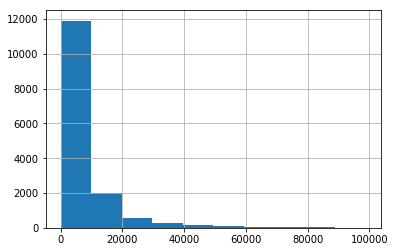

In [80]:
labels.hist()

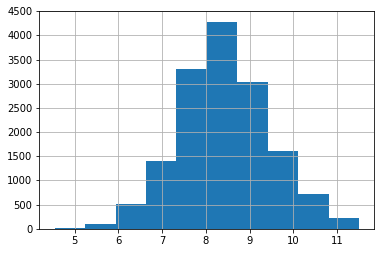

In [87]:
pd.Series(t).hist()